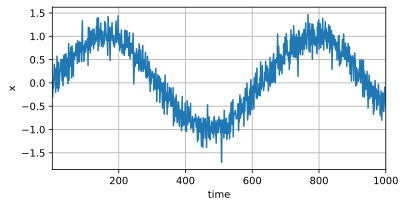

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

T=1000
time = torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(time*0.01)+torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [3]:
a=[1,2,3,4]
for i in range(4):
  print(i)
  print(a[0:i])


0
[]
1
[1]
2
[1, 2]
3
[1, 2, 3]


In [24]:
tau=4
feature=torch.zeros(T-tau,tau)
for i in range(tau):
  feature[:,i]=x[i:T-tau+i]
labels=x[tau:].reshape((-1,1))
batch_size,n_train=16,600
#bug 把label写出x，相当于没有reshape，然后进行了broadcast in loss
train_iter=d2l.load_array((feature[:n_train],labels[:n_train]),batch_size=batch_size,is_train=True)

In [25]:
def init_weight(m):
  if type(m)==nn.Linear:
    nn.init.xavier_uniform_(m.weight)

def get_net():
  net=nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
  #对每一个线性层进行初始化
  net.apply(init_weight)
  return net
#reduction=none 就不会自动sum
loss=nn.MSELoss(reduction='none')

def train(net,train_iter,loss,epoch,lr):
  trainer=torch.optim.Adam(net.parameters(),lr=lr)
  for i in range(epoch):
    L=0
    for x,y in train_iter:
      trainer.zero_grad()
      l=loss(net(x),y)
      l.sum().backward()
      #print(l)
      trainer.step()
      L+=l.sum()/batch_size
    print(f'epoch={i+1} loss={L}-{d2l.evaluate_loss(net,train_iter,loss)}')
net=get_net()
train(net,train_iter,loss,5,0.01)
    

epoch=1 loss=3.0388777256011963-0.05854341745376587
epoch=2 loss=2.1155877113342285-0.053115409562985105
epoch=3 loss=1.9630696773529053-0.050776944160461426
epoch=4 loss=1.8683775663375854-0.05092519780000051
epoch=5 loss=1.8957014083862305-0.04867571954925855


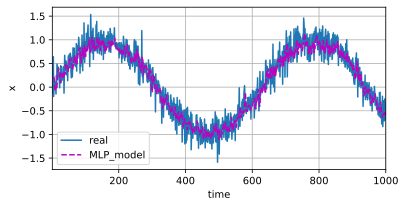

In [26]:
onestep_preds=net(feature)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',
legend=["real","MLP_model"],xlim=[1,1000],figsize=(6,3))

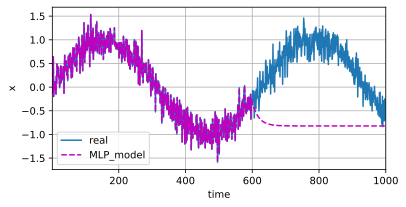

In [28]:
multistep_preds=torch.zeros(T)
multistep_preds[:n_train]=x[:n_train]
for i in range(n_train,T):
  multistep_preds[i]=net(multistep_preds[i-tau:i].reshape((1,-1)))

d2l.plot([time],[x.detach().numpy(),multistep_preds.detach().numpy()],'time','x',
legend=["real","MLP_model"],xlim=[1,1000],figsize=(6,3))

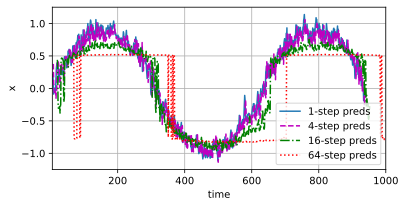

In [29]:
#can't understand
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))